In [ ]:
import spacy 
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords 
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.metrics import accuracy_score 
from sklearn.base import TransformerMixin 
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report 
import string
import matplotlib.pyplot as plt
fig = plt.figure()
import collections, numpy
punctuations = string.punctuation
!python3 -m spacy download en
spacy.load('en_core_web_sm')
from spacy.lang.en import English
parser = English()
import pandas as pd
import random
import inflect
p = inflect.engine()




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
def datapreprocessing(url):

  # Load the dataset into a pandas dataframe.
  df = pd.read_csv(url, delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

  sentences = df.sentence.values
  labels1 = df.label.values
  # correct=labels.count(1)
  
  train=[]
  actual_label=[]
  for i in range(len(df)):
    train.append((df.sentence[i],df.label[i]))
    actual_label.append(df.label[i])
  random.shuffle(train)

  train_data = train[:7000]
  test_data = train[7000:]
  actual_labels=actual_label[7000:]  
  return train_data,test_data,actual_labels,labels1

In [ ]:
train_data,test_data,labels,cor=datapreprocessing('/in_domain_train.tsv')

In [ ]:
collections.Counter(labels)

Counter({0: 451, 1: 1100})

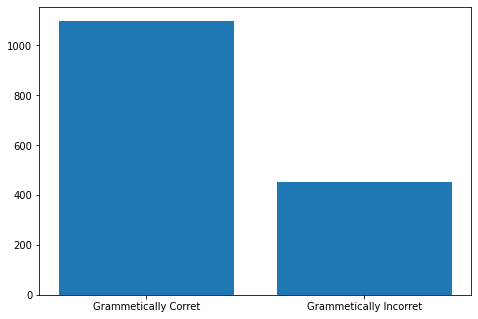

In [ ]:

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
classes = ['Grammetically Corret','Grammetically Incorret']
students = [1100,451]
ax.bar(classes,students)
plt.show()

In [ ]:
def model():
  #Custom transformer using spaCy 
  class predictors(TransformerMixin):
      def transform(self, X, **transform_params):
          return [clean_text(text) for text in X]
      def fit(self, X, y=None, **fit_params):
          return self
      def get_params(self, deep=True):
          return {}

  # Basic utility function to clean the text 
  def clean_text(text):     
      return text.strip()
  def spacy_tokenizer(sentence):
      tokens = parser(sentence)
      tokens = [ tok for tok in tokens]
      return tokens

  #create vectorizer object to generate feature vectors, we will use custom spacy tokenizer
  vectorizer = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1)) 
  classifier = LinearSVC()

  # Create the  pipeline to clean, tokenize, vectorize, and classify 
  pipe = Pipeline([("cleaner", predictors()),('vectorizer', vectorizer),('classifier', classifier)])
  
  return pipe

In [ ]:
def detection(sen):
  pipe=model()
  pipe.fit([x[0] for x in train_data], [x[1] for x in train_data]) 
  pred_data = pipe.predict(sen) 
  result=pred_data[0]
  return result

In [ ]:
pipe=model()
def accuracy(test_data,actual_label):
  pipe.fit([x[0] for x in train_data], [x[1] for x in train_data])
  pred_data = pipe.predict([x[0] for x in test_data])
  print ('Accuracy Score :',accuracy_score(labels, pred_data) )
  
  print ('Report : ')
  print (classification_report(labels, pred_data) )
   

In [ ]:
def punct_data(sen):
  # Load the dataset into a pandas dataframe.
  df = pd.read_csv('/punct.csv')
  
  sentences = df.sentence.values
  labels = df.lables.values
  train=[]
  for i in range(len(df)):
    train.append((df.sentence[i],df.lables[i]))
  
  random.shuffle(train)

  train_data = train[:200]
  test_data = train[200:]  
  class predictors(TransformerMixin):
      def transform(self, X, **transform_params):
          return [clean_text(text) for text in X]
      def fit(self, X, y=None, **fit_params):
          return self
      def get_params(self, deep=True):
          return {}
  def clean_text(text):     
      return text.strip().lower()
  def spacy_tokenizer(sentence):
      tokens = parser(sentence)
      tokens = [ tok.lower_ for tok in tokens]
      return tokens

  #create vectorizer object to generate feature vectors, we will use custom spacy tokenizer
  vectorizer = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1)) 
  classifier = LinearSVC()

  # Create the  pipeline to clean, tokenize, vectorize, and classify 
  pipe = Pipeline([("cleaner", predictors()),('vectorizer', vectorizer),('classifier', classifier)])
  pipe.fit([x[0] for x in train_data], [x[1] for x in train_data]) 
  pred_data = pipe.predict(sen) 
  result=pred_data[0]
  print(result)
  return result

In [ ]:
import spacy.cli
spacy.cli.download("en_core_web_lg")

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [ ]:
def article(sen):
  import nltk
  import en_core_web_lg
  nlp = en_core_web_lg.load()
  doc = nlp(sen)
  art_word=[]
  art=[]
  fl=0
  article=['a','an']
  for i,word in enumerate(doc):
    if(fl==1):
      art_word.append(word)
      fl=0
    st=str(word)
    if st in article:
      art.append(st)
      fl=1
      pass
  for i,word in enumerate(art_word):
    st=str(word)
    q=p.a(st)
    if((art[i]+" "+st)==q):
      return 1
    else:
      return 0
  

In [ ]:
def capital(sen):
  if sen[0].islower():
    print("Incorrect Capitalization")
  

In [ ]:
def check(sen):
  result=detection(sen)
  if result==1:
    print("Sentence is Grammetically Correct")
  else:
    print("Sentence is Grammetically Incorrect")
    punct=punctuation(sen)  
    if punct==0:
      print("Incorrect Punctuations")
    art=article(sen)  
    if art==0:
        print("Incorrect Article(a/an)")  
    capital(sen)   

Enter SentenceHello ,how are you?
Sentence is Grammetically Correct


In [ ]:
sen=[]
sen.append(input("Enter Sentence"))
check(sen[0])

In [ ]:
accuracy(test_data,labels)

Accuracy Score : 0.7092198581560284
Report : 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       451
           1       0.71      1.00      0.83      1100

    accuracy                           0.71      1551
   macro avg       0.35      0.50      0.41      1551
weighted avg       0.50      0.71      0.59      1551



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
